In [1]:
from ultralytics import YOLO
import torch

# Load model
model = YOLO("../models/fish_yolov86/weights/best.pt")

# Switch to training mode using PyTorch nn.Module
model.model.train()  # ✅ only affects nn.Module, no dataset needed

# Prepare a dummy input
x = torch.randn(1, 3, 640, 640, requires_grad=True)

# Optional: hook a layer for feature maps and gradients
feature_maps = {}
gradients = {}

def forward_hook(module, inp, out):
    feature_maps['layer'] = out

def backward_hook(module, grad_in, grad_out):
    gradients['layer'] = grad_out[0]

target_layer = model.model.model[0]  # first conv layer in backbone
hook_f = target_layer.register_forward_hook(forward_hook)
hook_b = target_layer.register_backward_hook(backward_hook)

# Forward pass
outputs = model.model(x)

# Fake loss to generate gradients
loss = outputs[0].sum()
loss.backward()

# Now gradients exist
print("Feature map shape:", feature_maps['layer'].shape)
print("Gradient shape:", gradients['layer'].shape)

# Remove hooks
hook_f.remove()
hook_b.remove()


/home/jassia/workspace/Jaasia/Fish_Detection/fish/lib/python3.11/site-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Feature map shape: torch.Size([1, 48, 320, 320])
Gradient shape: torch.Size([1, 48, 320, 320])


In [2]:
weights = torch.mean(gradients['layer'], dim=(2,3))  # shape: [1, 48]

In [3]:
gradcam_map = torch.zeros(feature_maps['layer'].shape[2:])  # [320, 320]
for i in range(weights.shape[1]):
    gradcam_map += weights[0, i] * feature_maps['layer'][0, i]


In [4]:
gradcam_map = torch.relu(gradcam_map)
gradcam_map -= gradcam_map.min()
gradcam_map /= gradcam_map.max()


# Heatmap of an Image

In [5]:
from PIL import Image
import torchvision.transforms as T
import torch

# Load your image
img = Image.open("../data/images/test/00000000_jpg.rf.5d9188ebfd1f9ae1b9989c8ffc6bd7c4.jpg").convert("RGB")

# Preprocess: resize and convert to tensor
transform = T.Compose([
    T.Resize((640, 640)),  # YOLO input size
    T.ToTensor()
])
x = transform(img).unsqueeze(0)  # add batch dimension: [1, 3, 640, 640]
x.requires_grad = True


In [6]:
classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

category = 'shark'          # pick the class you want to visualize
class_idx = classes.index(category)  # 4 in this case


In [13]:
# Forward pass
outputs = model.model(x)  # x is [1,3,640,640]

# Check output type
print(type(outputs[0]))  # usually <class 'ultralytics.nn.modules.Detections'>
print(outputs[0].shape)


<class 'torch.Tensor'>
torch.Size([1, 71, 80, 80])


In [9]:
# For batch size 1
preds = outputs[0]  # this might be a list of shape [1] containing a tensor

# Check type
print(type(preds))  # if <class 'list'>, unwrap it
if isinstance(preds, list):
    preds = preds[0]  # now preds.shape = [num_preds, 85]


<class 'torch.Tensor'>


In [11]:
import torch

class_idx = classes.index(category)  # e.g., 'shark' -> 4

# objectness and class score
obj_scores = preds[:, 4]
class_scores = preds[:, 5 + class_idx]
confidence = obj_scores * class_scores

# pick the index of the best detection
best_idx = torch.argmax(confidence)
pred = preds[best_idx]
score = confidence[best_idx].item()  # scalar


IndexError: index 1207 is out of bounds for dimension 0 with size 1

In [ ]:
model.model.zero_grad()
(score).backward(retain_graph=True)  # scalar backward


In [ ]:
# weights: global avg pool of gradients
weights = torch.mean(gradients['layer'], dim=(2,3))  # [1, C]

# GradCAM map
gradcam_map = torch.zeros(feature_maps['layer'].shape[2:], dtype=torch.float32)
for i in range(weights.shape[1]):
    gradcam_map += weights[0, i] * feature_maps['layer'][0, i]

gradcam_map = torch.relu(gradcam_map)
gradcam_map -= gradcam_map.min()
gradcam_map /= gradcam_map.max()

# Resize to original image
import cv2
gradcam_resized = cv2.resize(gradcam_map.detach().cpu().numpy(), (img.width, img.height))


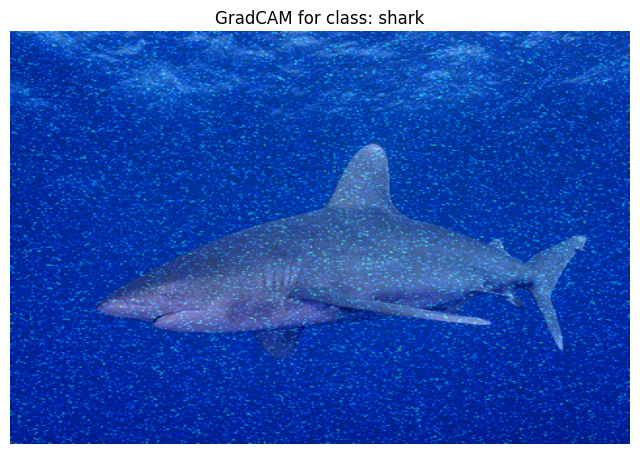

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

overlay = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

plt.imshow(overlay)
plt.axis('off')
plt.title(f'GradCAM: {category}, Score: {score:.3f}')
plt.show()
